In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)

import os
zad1_dir = "zad1"
os.makedirs(zad1_dir, exist_ok=True)
zad2_dir = "zad2"
os.makedirs(zad2_dir, exist_ok=True)
zad3_dir = "zad3"
os.makedirs(zad3_dir, exist_ok=True)
zad4_dir = "zad4"
os.makedirs(zad4_dir, exist_ok=True)

In [8]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# zad 1

In [9]:
n_values = [20, 50, 100]
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
m_trials = 5
n_simulations = 10000
threshold = 3

In [ ]:
# Funkcja teoretyczna g(p) = P(X >= 3)
def calculate_true_theta(p, m, k):
    return binom.sf(k-1, m, p)

In [11]:
results_list = []
metrics_list = []

for n in n_values:
    for p in p_values:
        # wiersze - próby rozmiaru n, kolumny - obserwacje w próbie
        data = np.random.binomial(n=m_trials, p=p, size=(n_simulations, n))
        
        # estymator p_hat = średnia z próby / m_trials
        p_hats = data.mean(axis=1) / m_trials
        
        # estymator theta_hat = P(X >= 3 | p=p_hat)
        theta_hats = binom.sf(threshold-1, m_trials, p_hats)
        
        # 4. Prawdziwa wartość theta
        true_theta = calculate_true_theta(p, m_trials, threshold)
        
        for val in theta_hats:
            results_list.append({
                "n": n,
                "p": p,
                "theta_hat": val,
                "true_theta": true_theta
            })
            
        bias = np.mean(theta_hats) - true_theta
        variance = np.var(theta_hats)
        mse = np.mean((theta_hats - true_theta)**2)
        
        metrics_list.append({
            "n": n,
            "p": p,
            "Bias": bias,
            "Variance": variance,
            "MSE": mse
        })

df_results = pd.DataFrame(results_list)
df_metrics = pd.DataFrame(metrics_list)

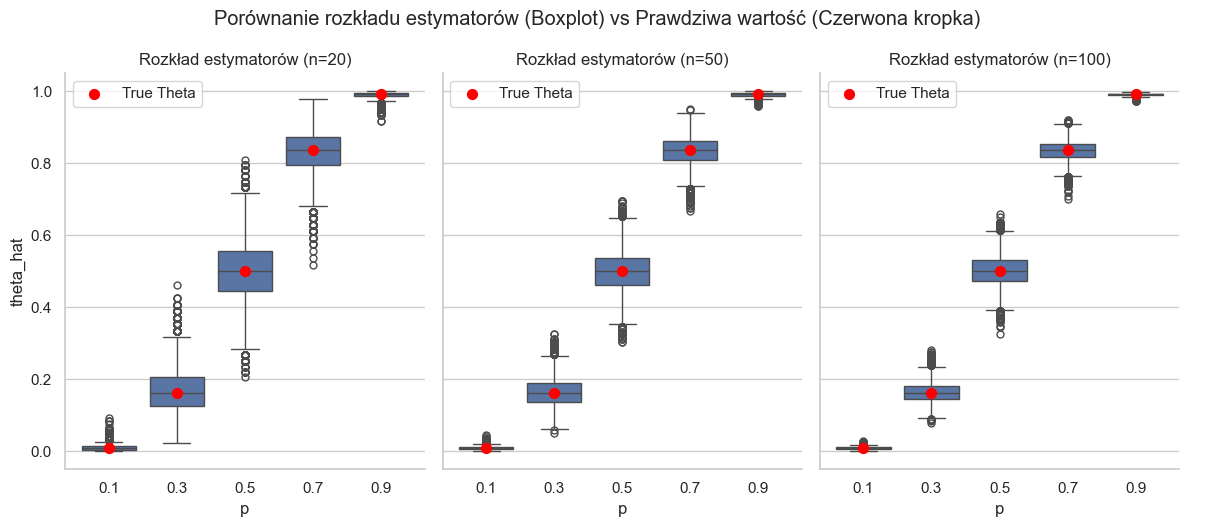

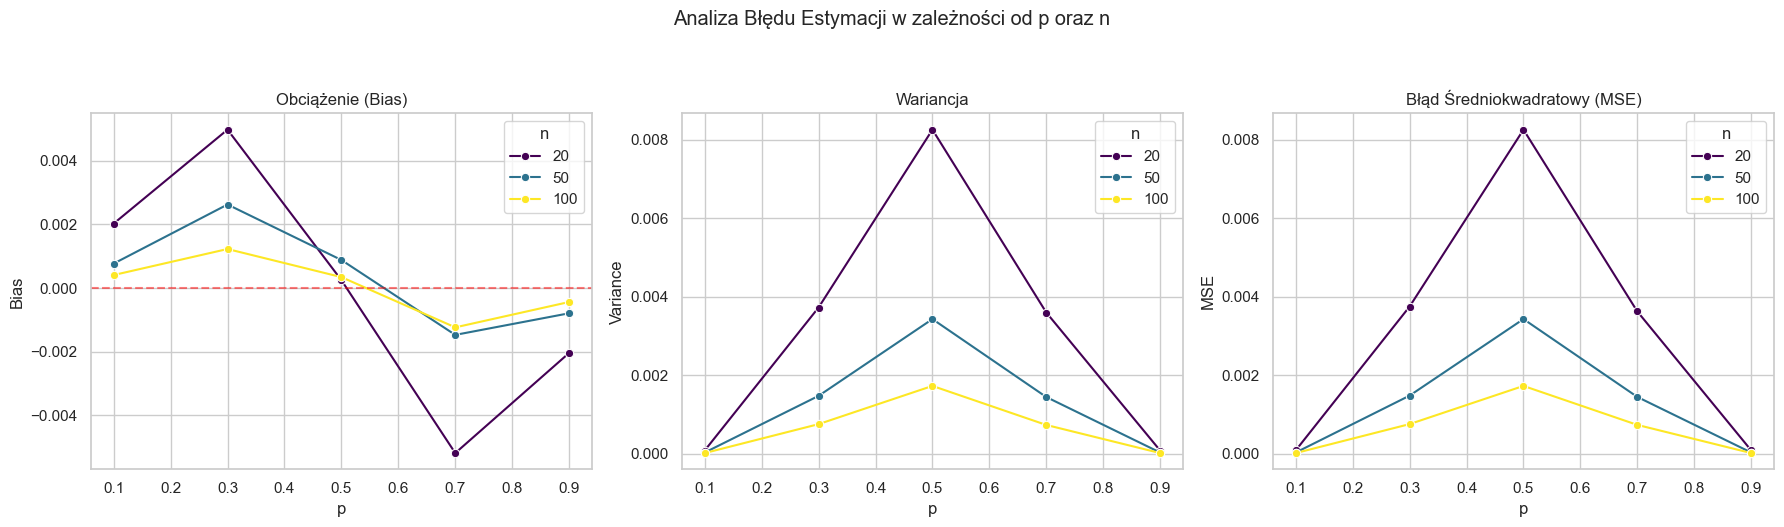

In [12]:
g = sns.catplot(
    data=df_results, 
    x="p", 
    y="theta_hat", 
    col="n", 
    kind="box", 
    sharey=True,
    height=5, 
    aspect=0.8
)

for ax, n_val in zip(g.axes.flat, n_values):
    true_thetas = [calculate_true_theta(p, m_trials, threshold) for p in p_values]
    ax.scatter(range(len(p_values)), true_thetas, color='red', zorder=5, label='True Theta', s=50)
    ax.set_title(f"Rozkład estymatorów (n={n_val})")
    ax.legend(loc='upper left')

plt.suptitle("Porównanie rozkładu estymatorów (Boxplot) vs Prawdziwa wartość (Czerwona kropka)", y=1.05)
# plt.show()
plot_filename = os.path.join(zad1_dir, f"boxplots.png")
plt.savefig(plot_filename, bbox_inches='tight')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=df_metrics, x="p", y="Bias", hue="n", marker="o", palette="viridis", ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title("Obciążenie (Bias)")

sns.lineplot(data=df_metrics, x="p", y="Variance", hue="n", marker="o", palette="viridis", ax=axes[1])
axes[1].set_title("Wariancja")

sns.lineplot(data=df_metrics, x="p", y="MSE", hue="n", marker="o", palette="viridis", ax=axes[2])
axes[2].set_title("Błąd Średniokwadratowy (MSE)")

plt.suptitle("Analiza Błędu Estymacji w zależności od p oraz n", y=1.05)
plt.tight_layout()
# plt.show()
plot_filename = os.path.join(zad1_dir, f"metrics.png")
plt.savefig(plot_filename, bbox_inches='tight')

# Zad 2

In [15]:
import scipy.stats as stats
import math

In [16]:
n_values = [20, 50, 100]
theta_values = [0.5, 1, 2, 5]
n_simulations = 10000


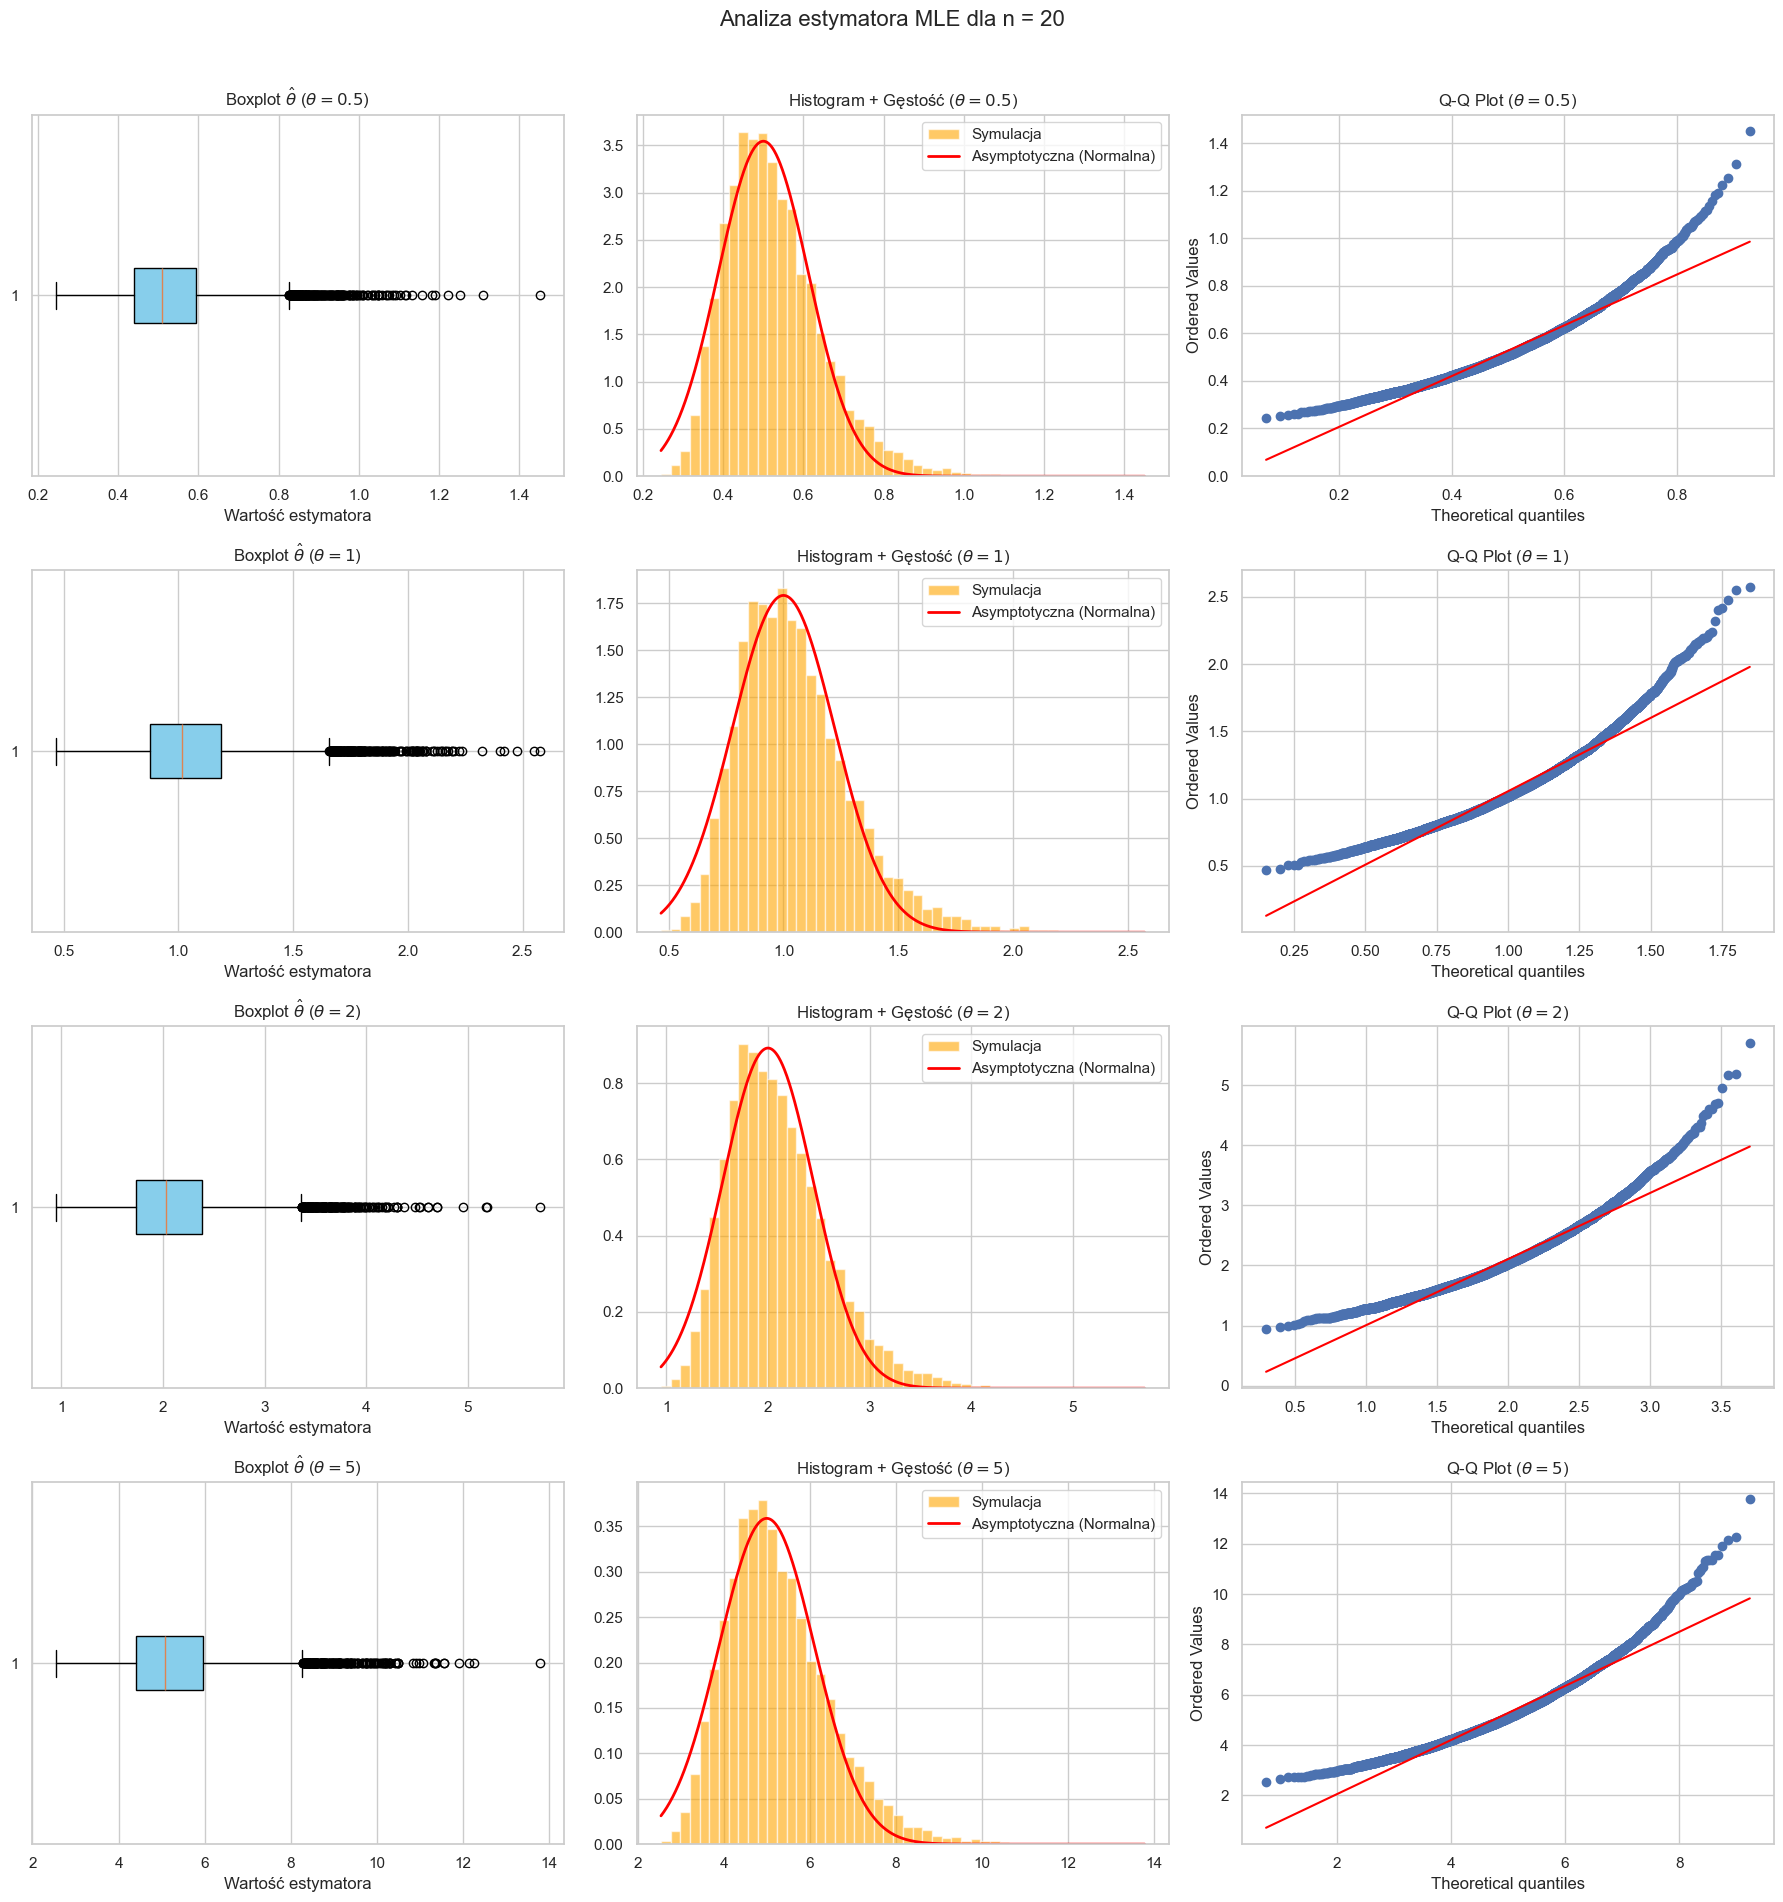

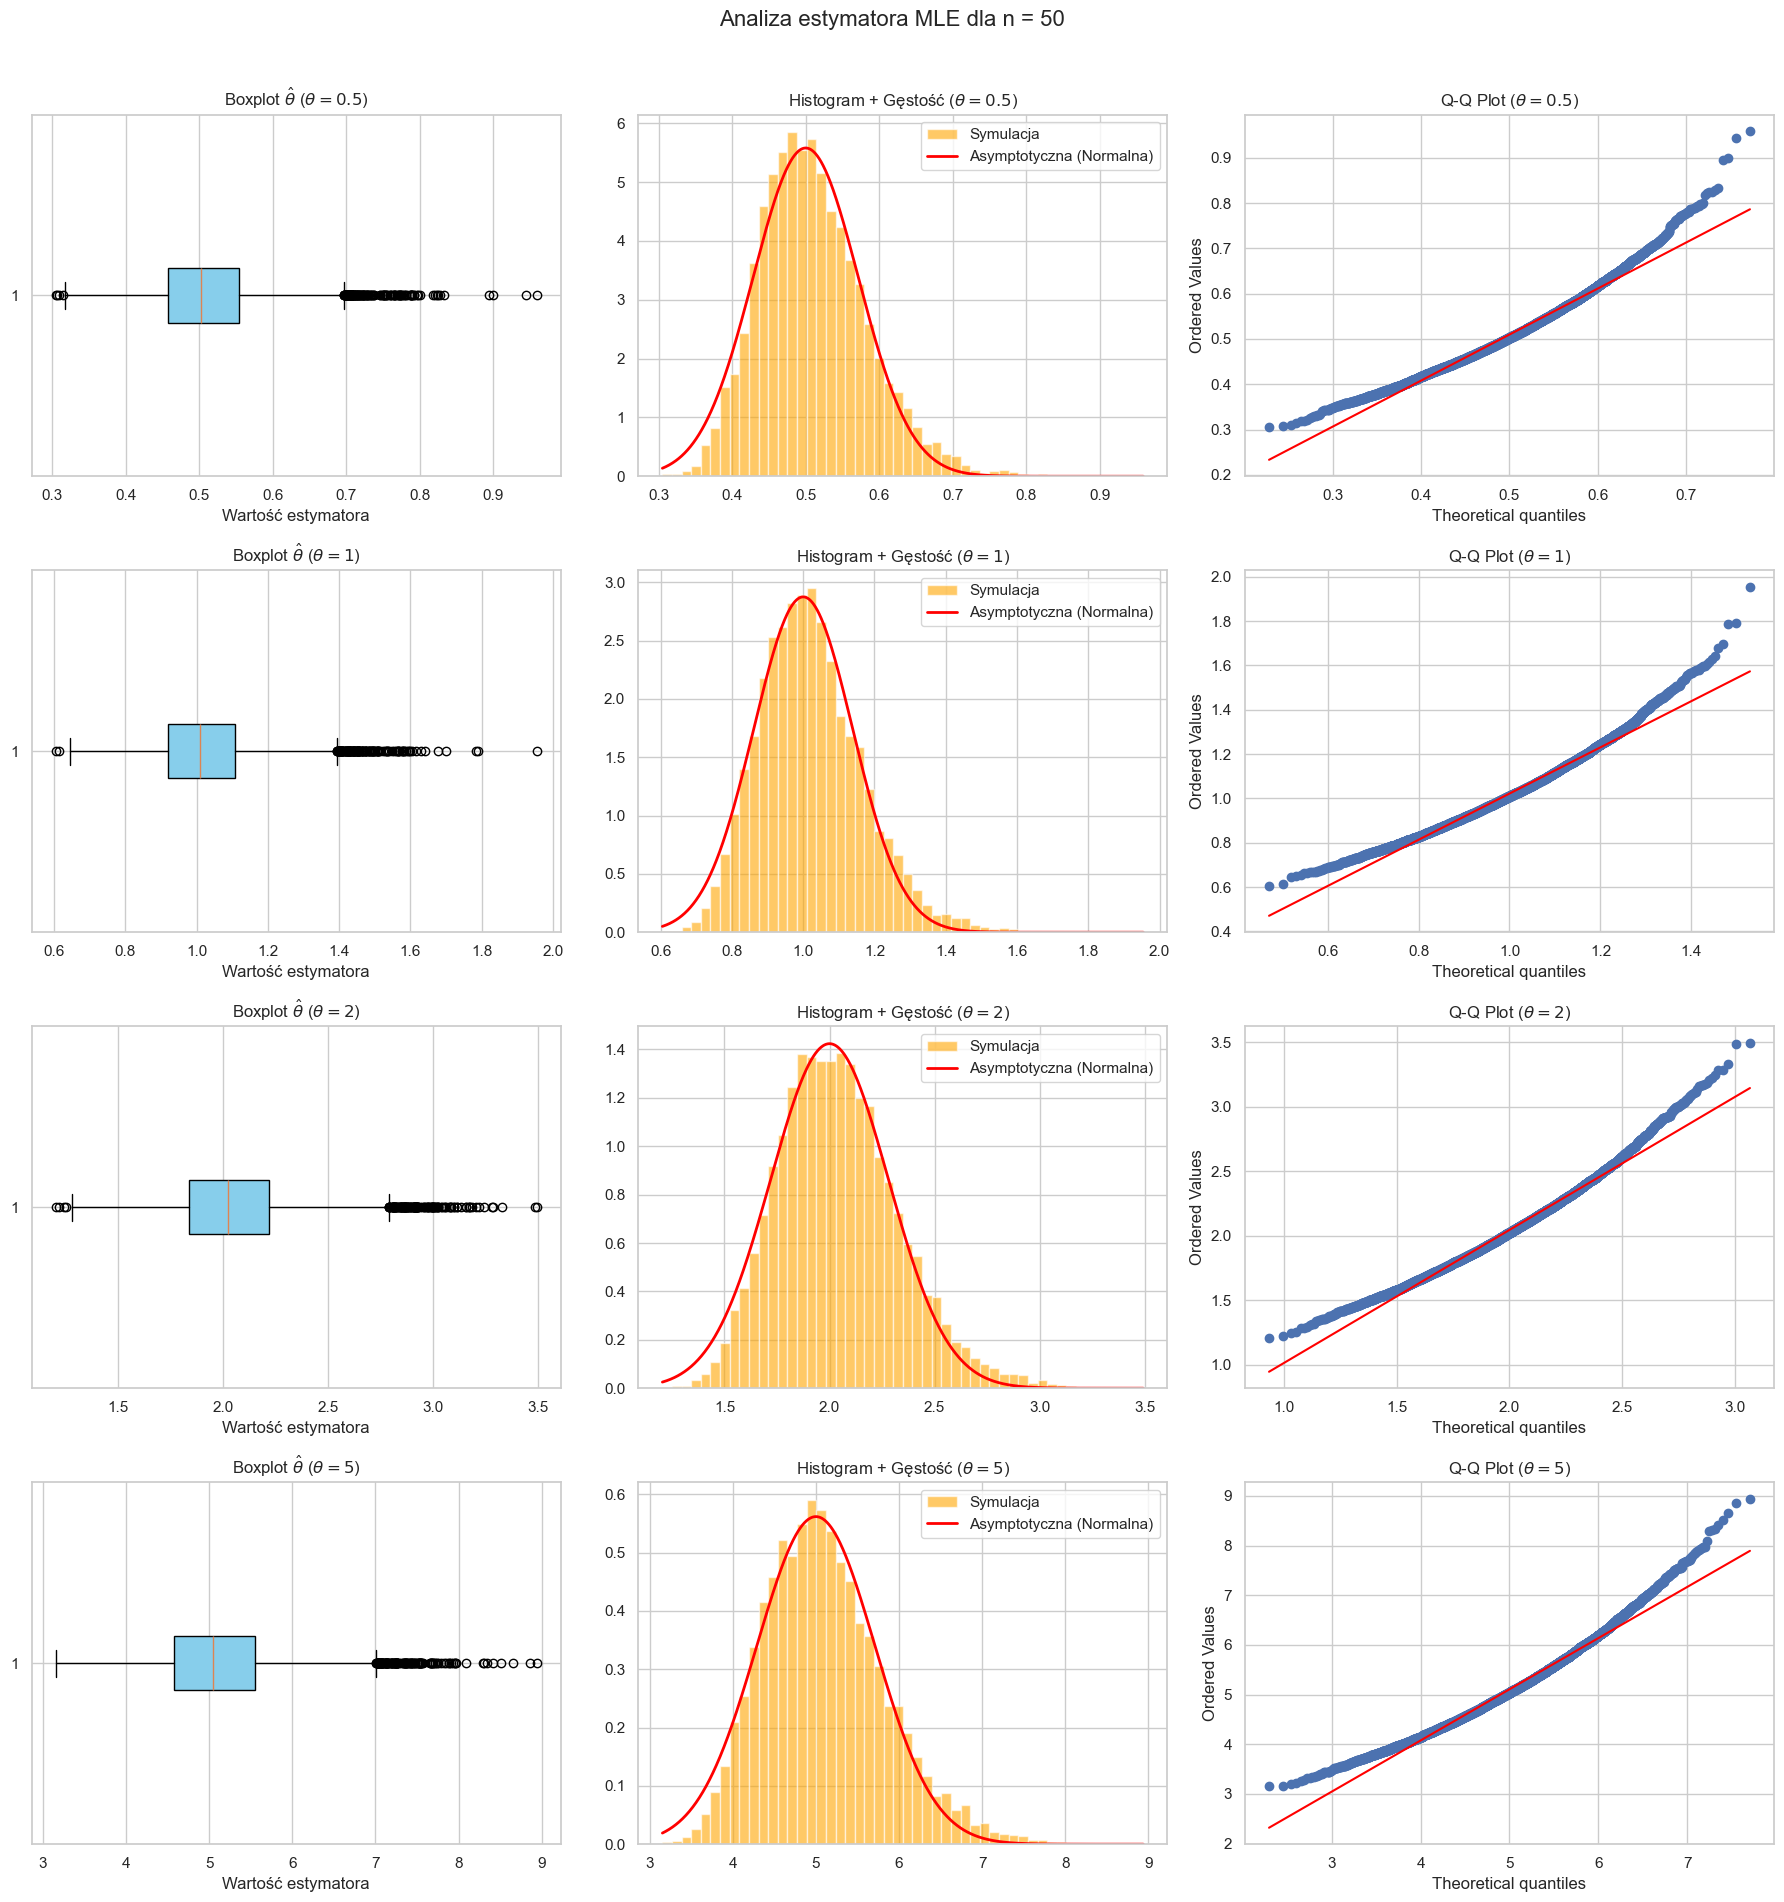

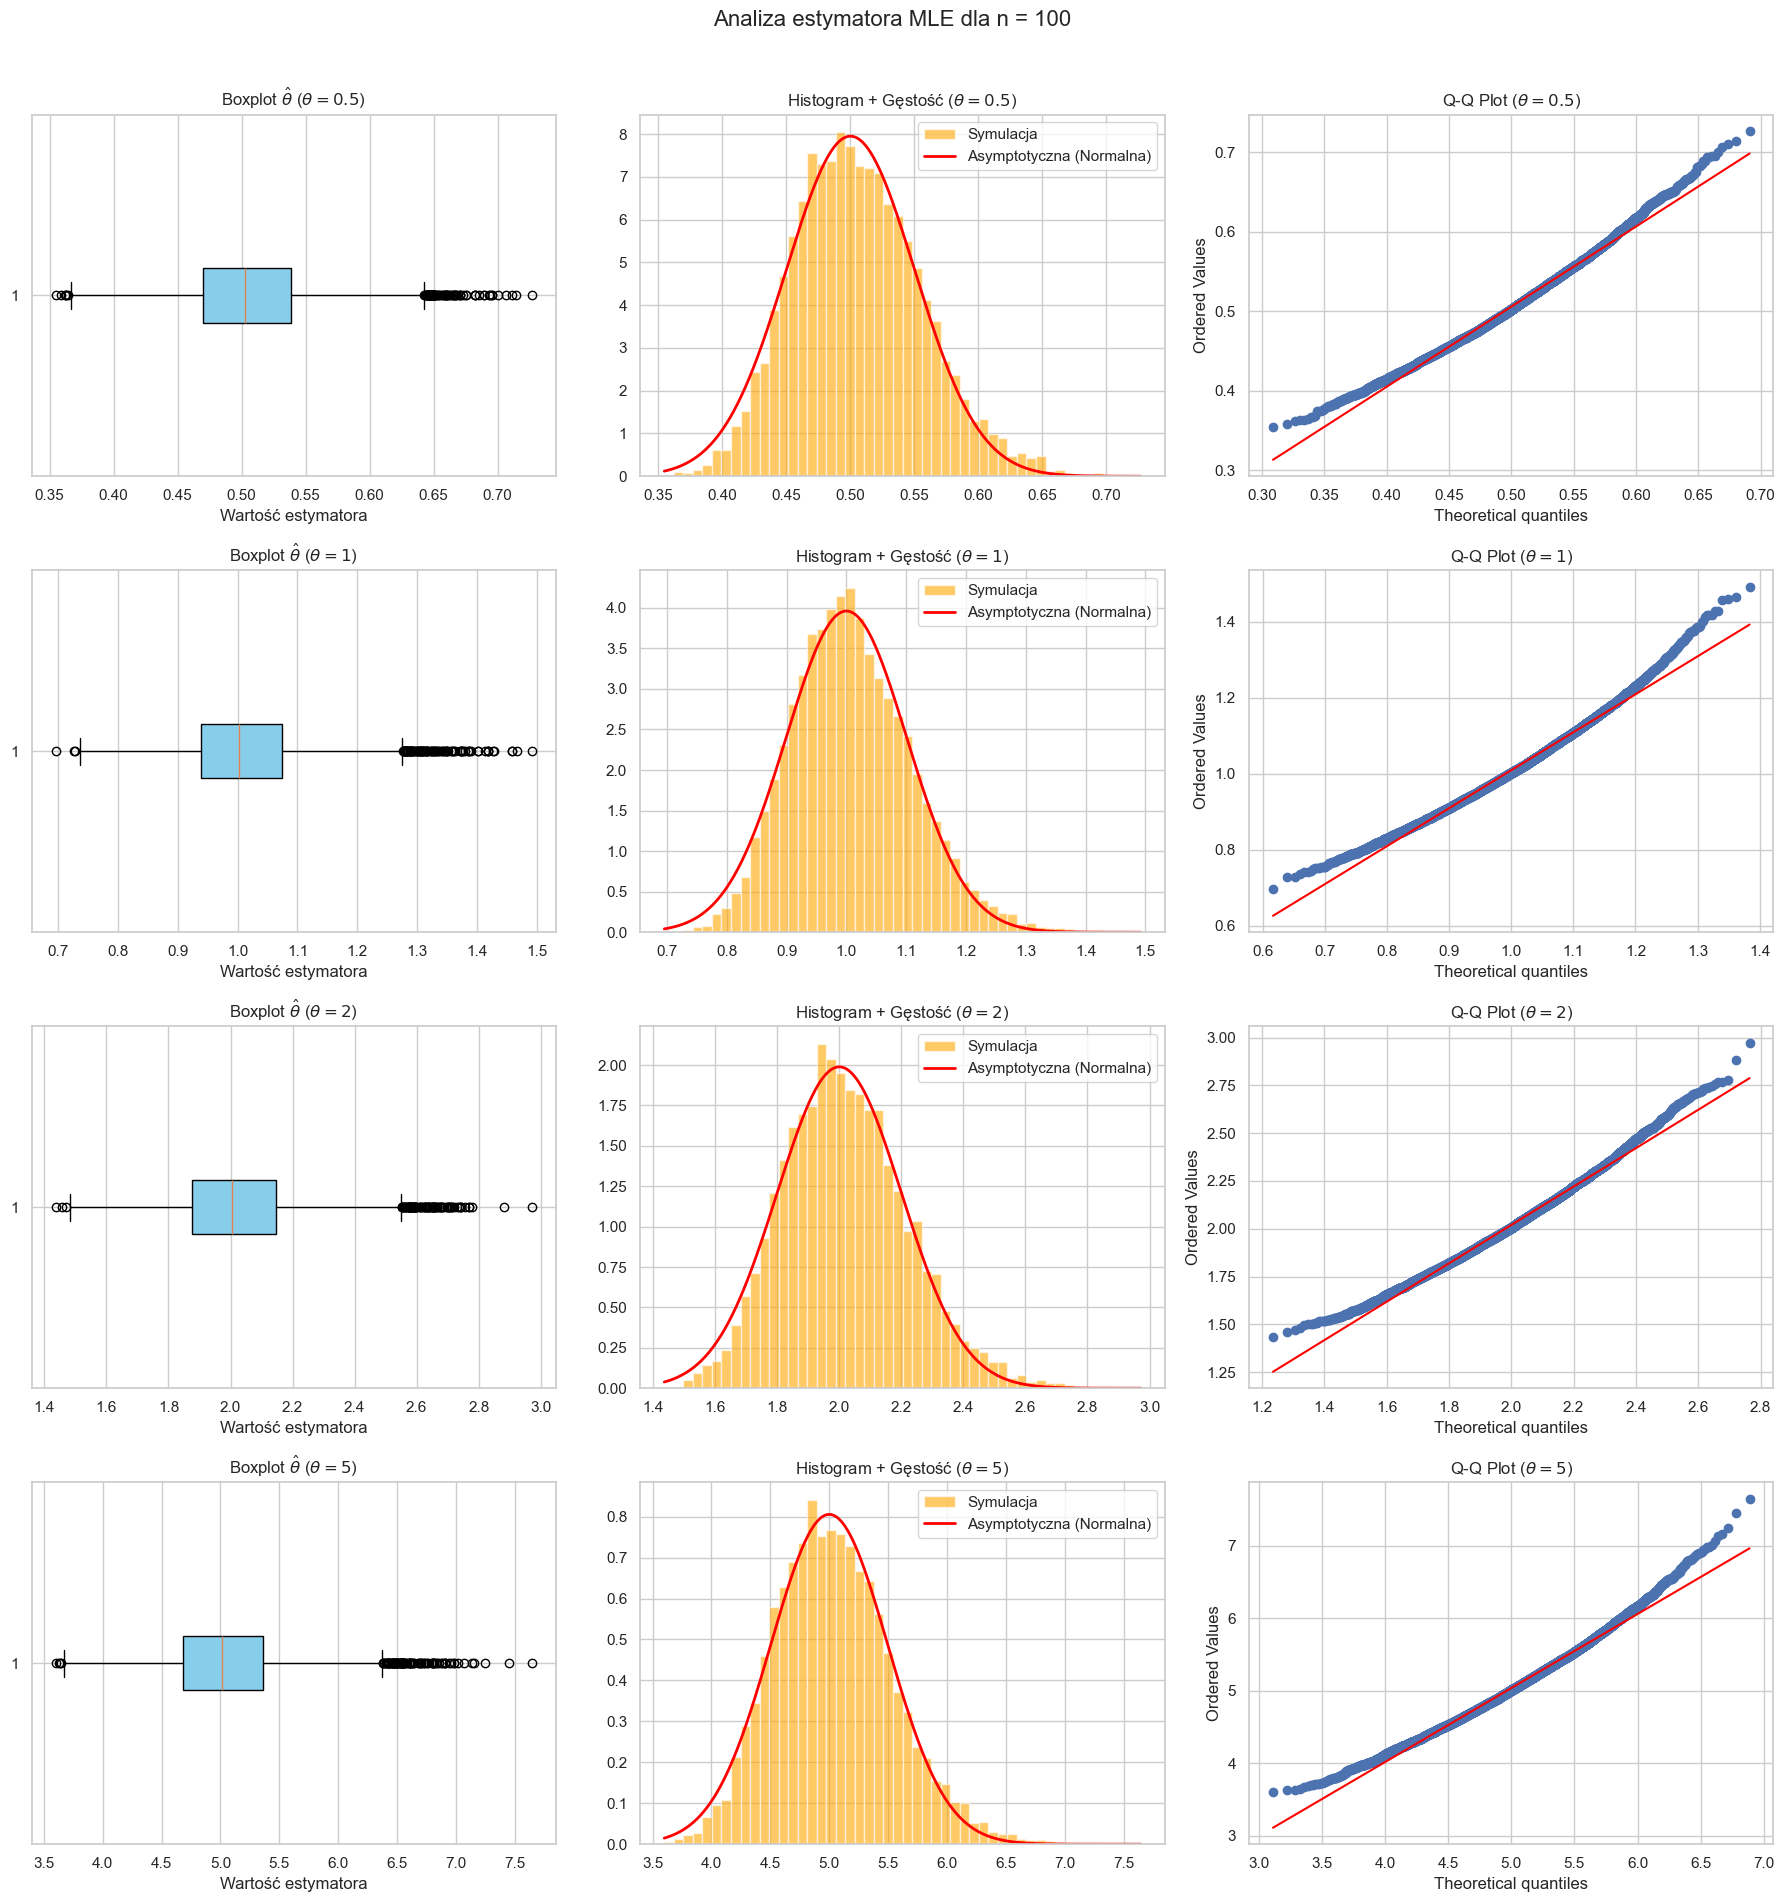

In [22]:
for n in n_values:
    fig, axes = plt.subplots(len(theta_values), 3, figsize=(18, 5 * len(theta_values)))
    fig.suptitle(f'Analiza estymatora MLE dla n = {n}', fontsize=16)
    
    for i, theta in enumerate(theta_values):
        data_fisher = np.random.beta(theta, 1, size=(n_simulations, n)) # fisher info - 10000 wierszy, w każdym n próbek
        
        log_vals_fisher = np.log(data_fisher)
        score_values = (n / theta) + np.sum(log_vals_fisher, axis=1) # pochodna log-likelihood (dla każdego z 10000 wierszy)
        
        var_score = np.var(score_values)
        estimated_fisher_info = var_score / n
        
        theoretical_fisher = 1 / (theta**2)
                
        # theta_mle (10000 wierszy, w każdym n próbek)
        data_mle = np.random.beta(theta, 1, size=(n_simulations, n))
        
        sum_log_x = np.sum(np.log(data_mle), axis=1)
        theta_hats = -n / sum_log_x
        
        row = axes[i] if len(theta_values) > 1 else axes
        
        # boxplot
        row[0].boxplot(theta_hats, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
        row[0].set_title(f'Boxplot $\\hat{{\\theta}}$ ($\\theta={theta}$)')
        row[0].set_xlabel('Wartość estymatora')
        
        # histogram
        count, bins, ignored = row[1].hist(theta_hats, bins=50, density=True, alpha=0.6, color='orange', label='Symulacja')
        
        # rozkład asymptotyczny: N(theta, 1 / (n * wyestymowana_informacja_fishera))
        asymp_mean = theta
        asymp_std = np.sqrt(1 / (n * estimated_fisher_info))
        
        x_line = np.linspace(min(bins), max(bins), 1000)
        pdf = stats.norm.pdf(x_line, asymp_mean, asymp_std)
        row[1].plot(x_line, pdf, linewidth=2, color='red', label='Asymptotyczna (Normalna)')
        row[1].set_title(f'Histogram + Gęstość ($\\theta={theta}$)')
        row[1].legend()
        
        # Q-Q plot
        stats.probplot(theta_hats, dist="norm", sparams=(asymp_mean, asymp_std), plot=row[2])
        row[2].get_lines()[1].set_color('red')
        row[2].set_title(f'Q-Q Plot ($\\theta={theta}$)')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    # plt.show()
    plot_filename = os.path.join(zad2_dir, f"plots_n_{n}.png")
    plt.savefig(plot_filename, bbox_inches='tight')

# Zad 3

In [23]:
from scipy.stats import logistic
from scipy.optimize import minimize

In [24]:
# negatywna log-wiarygodność aby dopasować się do scipy.optimize.minimize
def neg_log_likelihood(theta, data, sigma):
    t = theta[0]
    log_likelihoods = logistic.logpdf(data, loc=t, scale=sigma)
    return -np.sum(log_likelihoods)

def run_mle_scipy(data, sigma, start_theta):
    result = minimize(
        fun=neg_log_likelihood,
        x0=[start_theta],
        args=(data, sigma),
        method='BFGS' 
    )
    return result.x[0], result.nit

In [ ]:
# analiza punktu startowego
test_n = 50
test_theta = 4
test_sigma = 2
dummy_data = logistic.rvs(loc=test_theta, scale=test_sigma, size=test_n)

start_points = [0, 4, 10, -20, np.mean(dummy_data)]

with open(os.path.join(zad3_dir, "mle_starting_points.md"), "w") as f:
    f.write("| Punkt startowy | Estymator | Iteracje |\n")
    f.write("|----------------|-----------|----------|\n")
    for start in start_points:
        est, iters = run_mle_scipy(dummy_data, test_sigma, start)
        f.write(f"| {start:14.2f} | {est:.4f} | {iters} |\n")

In [42]:
n_values = [20, 50, 100]
scenarios = [
    {'label': '(a)', 'theta': 0, 'sigma': 1},
    {'label': '(b)', 'theta': 0, 'sigma': 2},
    {'label': '(c)', 'theta': 4, 'sigma': 1},
    {'label': '(d)', 'theta': 4, 'sigma': 2}
]
n_simulations = 10000

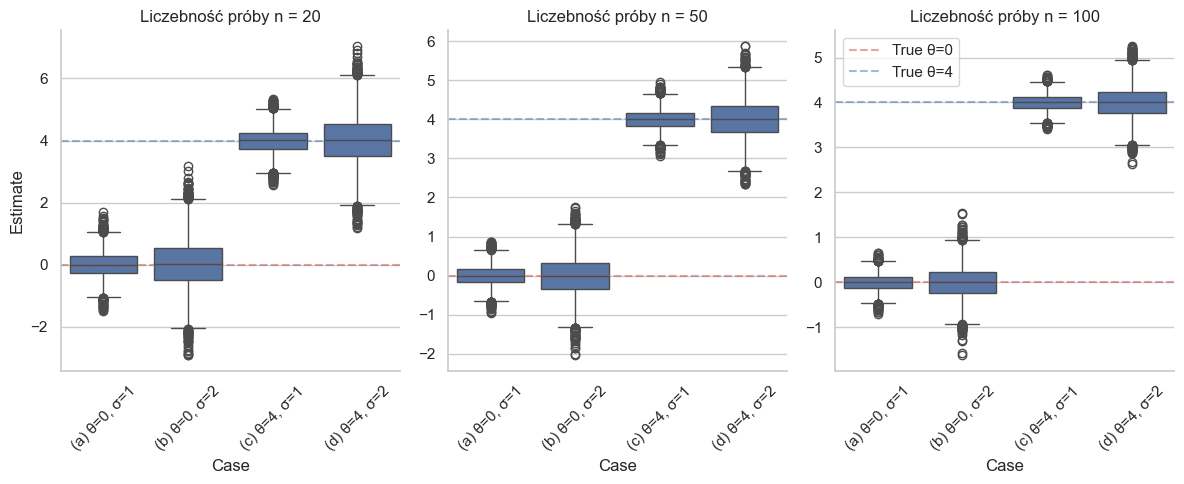

In [43]:
results = []
for n in n_values:
    for scen in scenarios:
        true_theta = scen['theta']
        true_sigma = scen['sigma']
        label = scen['label']
        
        estimates = np.zeros(n_simulations)
        
        for i in range(n_simulations):
            data = logistic.rvs(loc=true_theta, scale=true_sigma, size=n)

            theta_hat, _ = run_mle_scipy(data, true_sigma, start_theta=np.mean(data))
            estimates[i] = theta_hat
            
        bias = np.mean(estimates) - true_theta
        variance = np.var(estimates)
        mse = np.mean((estimates - true_theta)**2)
        
        results.append({
            'N': n,
            'Case': f"{label} θ={true_theta}, σ={true_sigma}",
            'Bias': bias,
            'Variance': variance,
            'MSE': mse,
            'Estimates': estimates
        })

stats_df = pd.DataFrame(results).drop(columns=['Estimates'])
# print("\nWyniki statystyczne:")
# print(stats_df.round(4).to_string(index=False))#
with open(os.path.join(zad3_dir, "mle_statistics.md"), "w") as f:
    f.write(stats_df.round(4).to_markdown(index=False))

plot_data = []
for r in results:
    for val in r['Estimates']:
        plot_data.append({'N': r['N'], 'Case': r['Case'], 'Estimate': val})
plot_df = pd.DataFrame(plot_data)

g = sns.FacetGrid(plot_df, col="N", sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "Case", "Estimate", order=[s['Case'] for s in results if s['N']==20])

for ax, n_val in zip(g.axes.flat, n_values):
    ax.set_title(f"Liczebność próby n = {n_val}")
    ax.axhline(0, color='r', linestyle='--', alpha=0.5, label='True θ=0')
    ax.axhline(4, color='b', linestyle='--', alpha=0.5, label='True θ=4')
    ax.tick_params(axis='x', rotation=45)

plt.legend()
plt.tight_layout()
# plt.show()
plot_filename = os.path.join(zad3_dir, f"mle_boxplots.png")
plt.savefig(plot_filename, bbox_inches='tight')

# Zad 4.a



In [46]:
def calculate_mle(data):
    #-n / sum(ln(x_i))
    n = len(data)
    log_sum = np.sum(np.log(data))
    return -n / log_sum

def calculate_mom(data):
    #mean / (1 - mean)
    mean_val = np.mean(data)
    return mean_val / (1 - mean_val)

In [47]:
def run_simulation(n_values, theta_values, iterations=10000):
    raw_data_list = []
    metrics_list = []

    for theta in theta_values:
        for n in n_values:
            mle_estimates = []
            mom_estimates = []
            
            for _ in range(iterations):
                sample = np.random.beta(theta, 1, size=n)
                mle_estimates.append(calculate_mle(sample))
                mom_estimates.append(calculate_mom(sample))
            
            mle_estimates = np.array(mle_estimates)
            mom_estimates = np.array(mom_estimates)
            
            df_mle = pd.DataFrame({
                'theta': theta,
                'n': n,
                'Estimate': mle_estimates,
                'Method': 'MLE'
            })

            df_mom = pd.DataFrame({
                'theta': theta,
                'n': n,
                'Estimate': mom_estimates,
                'Method': 'MOM'
            })
            raw_data_list.extend([df_mle, df_mom])

            bias_mle = np.mean(mle_estimates) - theta
            bias_mom = np.mean(mom_estimates) - theta
            mse_mle = np.mean((mle_estimates - theta)**2)
            mse_mom = np.mean((mom_estimates - theta)**2)
            var_mle = np.var(mle_estimates)
            var_mom = np.var(mom_estimates)
            
            metrics_list.append({'theta': theta, 'n': n, 'Method': 'MLE', 
                                 'Bias': bias_mle, 'MSE': mse_mle, 'Variance': var_mle})
            metrics_list.append({'theta': theta, 'n': n, 'Method': 'MOM', 
                                 'Bias': bias_mom, 'MSE': mse_mom, 'Variance': var_mom})

    return pd.concat(raw_data_list, ignore_index=True), pd.DataFrame(metrics_list)

In [51]:
def plot_boxplots(df_raw, theta_values):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, theta in enumerate(theta_values):
        ax = axes[i]
        subset = df_raw[df_raw['theta'] == theta]
        
        sns.boxplot(data=subset, x='n', y='Estimate', hue='Method', ax=ax, palette="Set2", showfliers=False)
        
        ax.axhline(theta, color='red', linestyle='--', linewidth=2, label=f'True Theta={theta}')
        
        ax.set_title(f'Rozkład estymatorów dla Theta = {theta}')
        ax.set_xlabel('Rozmiar próby (n)')
        ax.set_ylabel('Wartość estymatora')
        ax.legend(loc='upper right')

    plt.suptitle('Porównanie rozkładów estymatorów (Boxploty)', fontsize=16)
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(zad4_dir, f"boxplots_a.png")
    plt.savefig(plot_filename, bbox_inches='tight')

def plot_metrics(df_metrics, theta_values):
    metrics = ['Bias', 'MSE', 'Variance']
    
    for metric in metrics:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for i, theta in enumerate(theta_values):
            ax = axes[i]
            subset = df_metrics[df_metrics['theta'] == theta]
            
            sns.lineplot(data=subset, x='n', y=metric, hue='Method', marker='o', ax=ax, palette=['blue', 'orange'])
            
            if metric == 'Bias':
                ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
                
            ax.set_title(f'{metric} vs n (Theta={theta})')
            ax.set_xticks([20, 50, 100])
            ax.set_xlabel('Rozmiar próby (n)')
            ax.set_ylabel(metric)
        
        plt.suptitle(f'Zależność {metric} od liczebności próby n', fontsize=16)
        plt.tight_layout()
        # plt.show()
        plot_filename = os.path.join(zad4_dir, f"{metric.lower()}_a.png")
        plt.savefig(plot_filename, bbox_inches='tight')

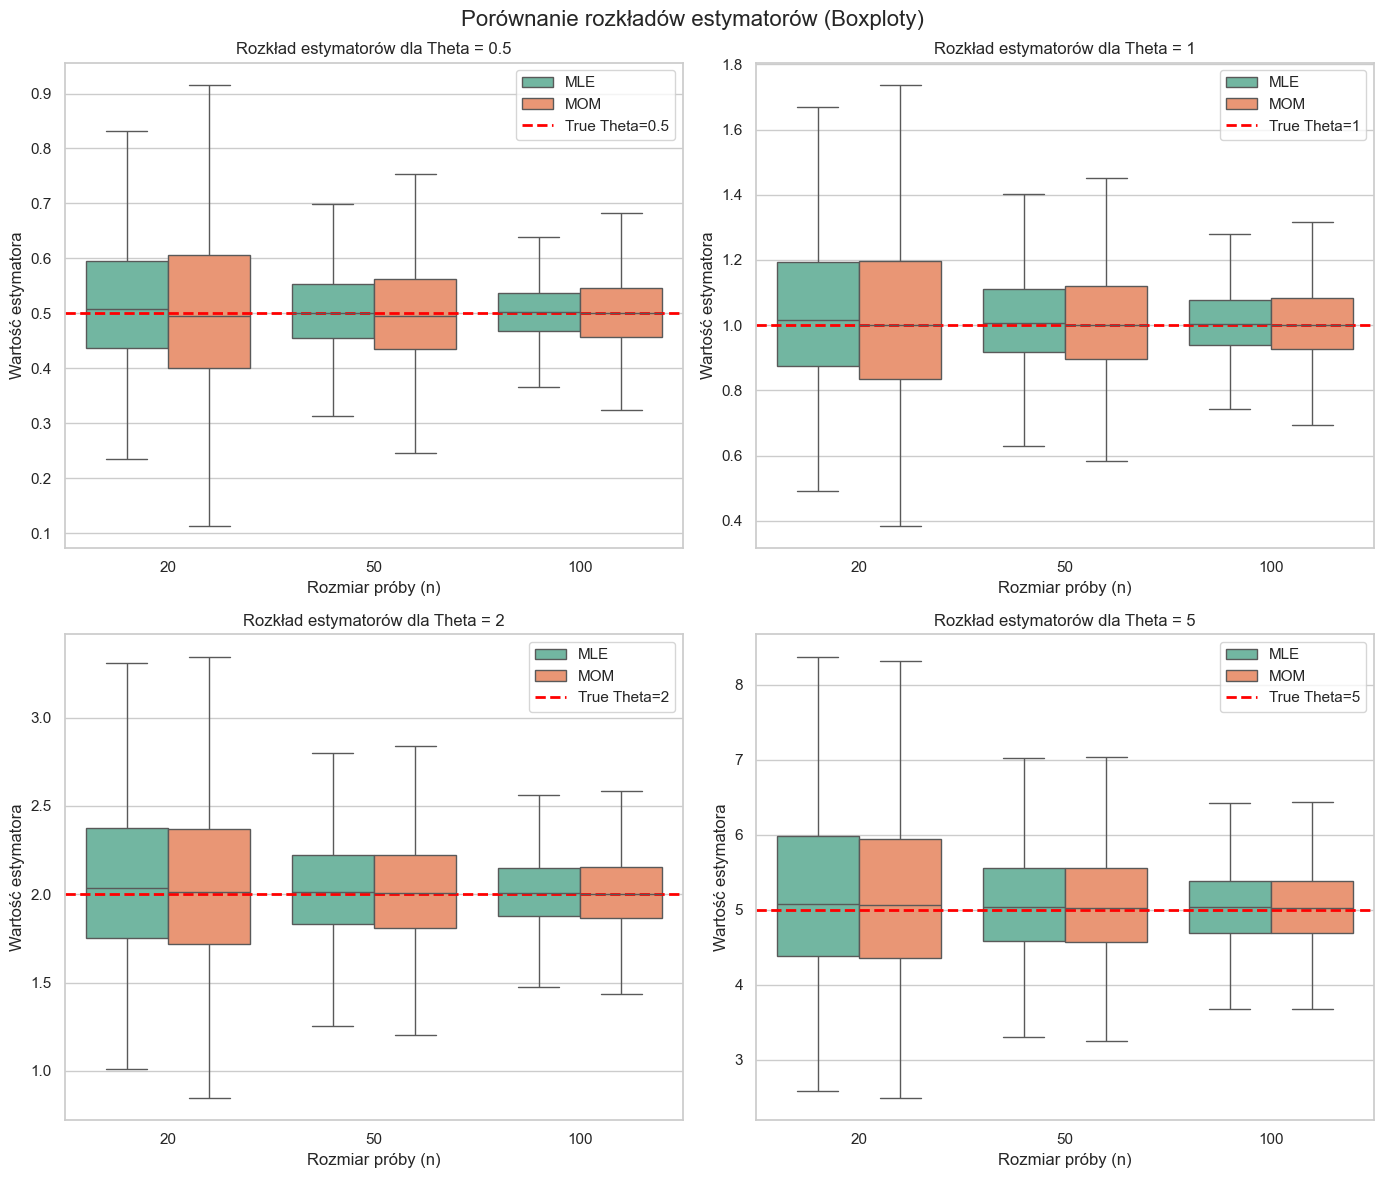

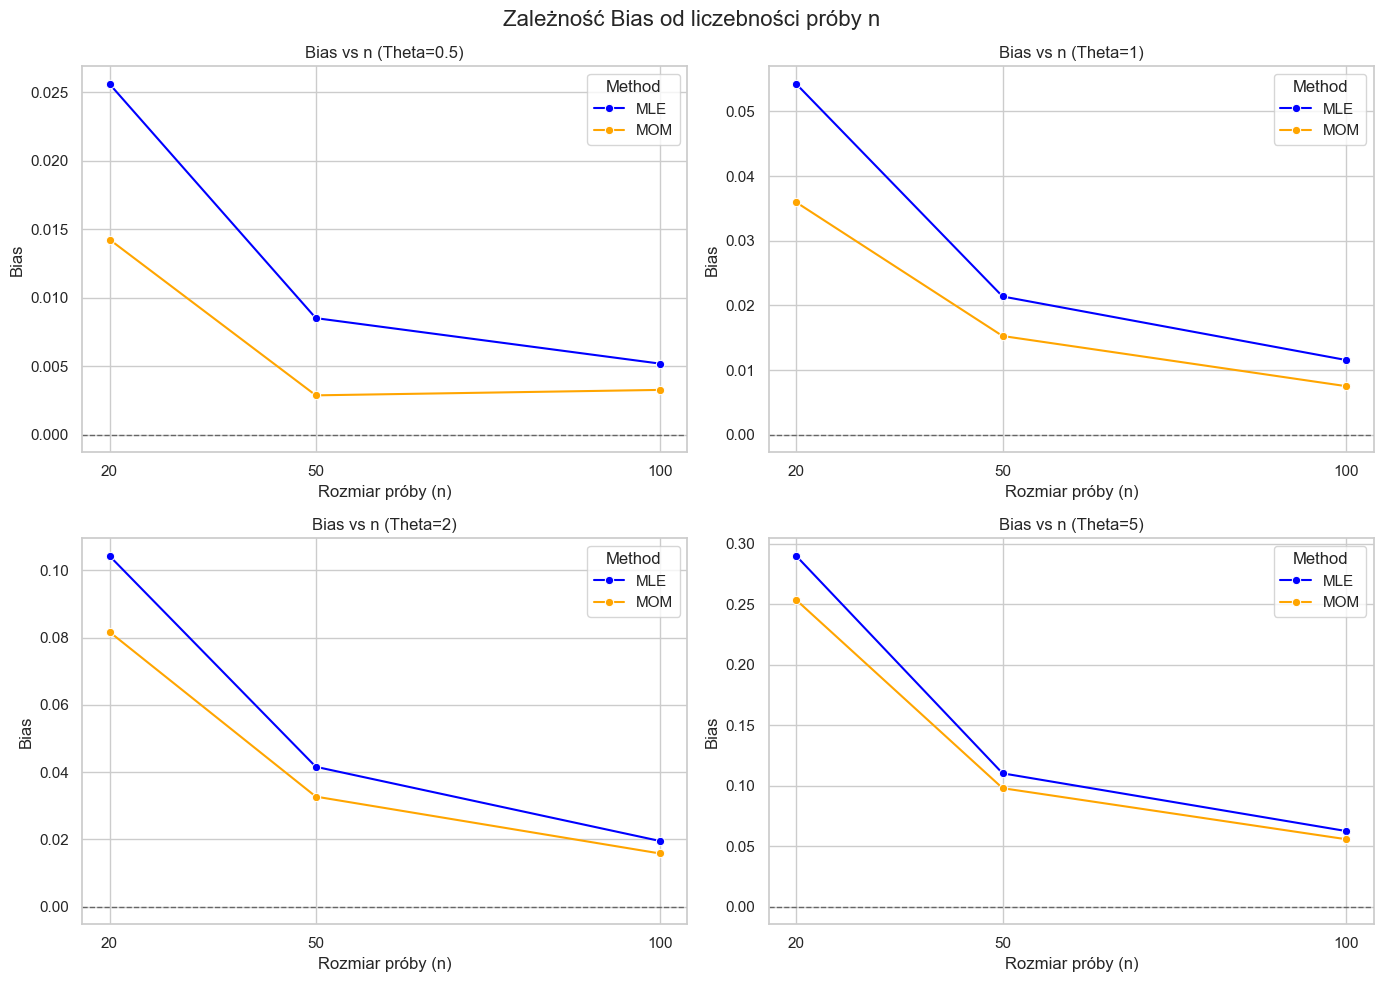

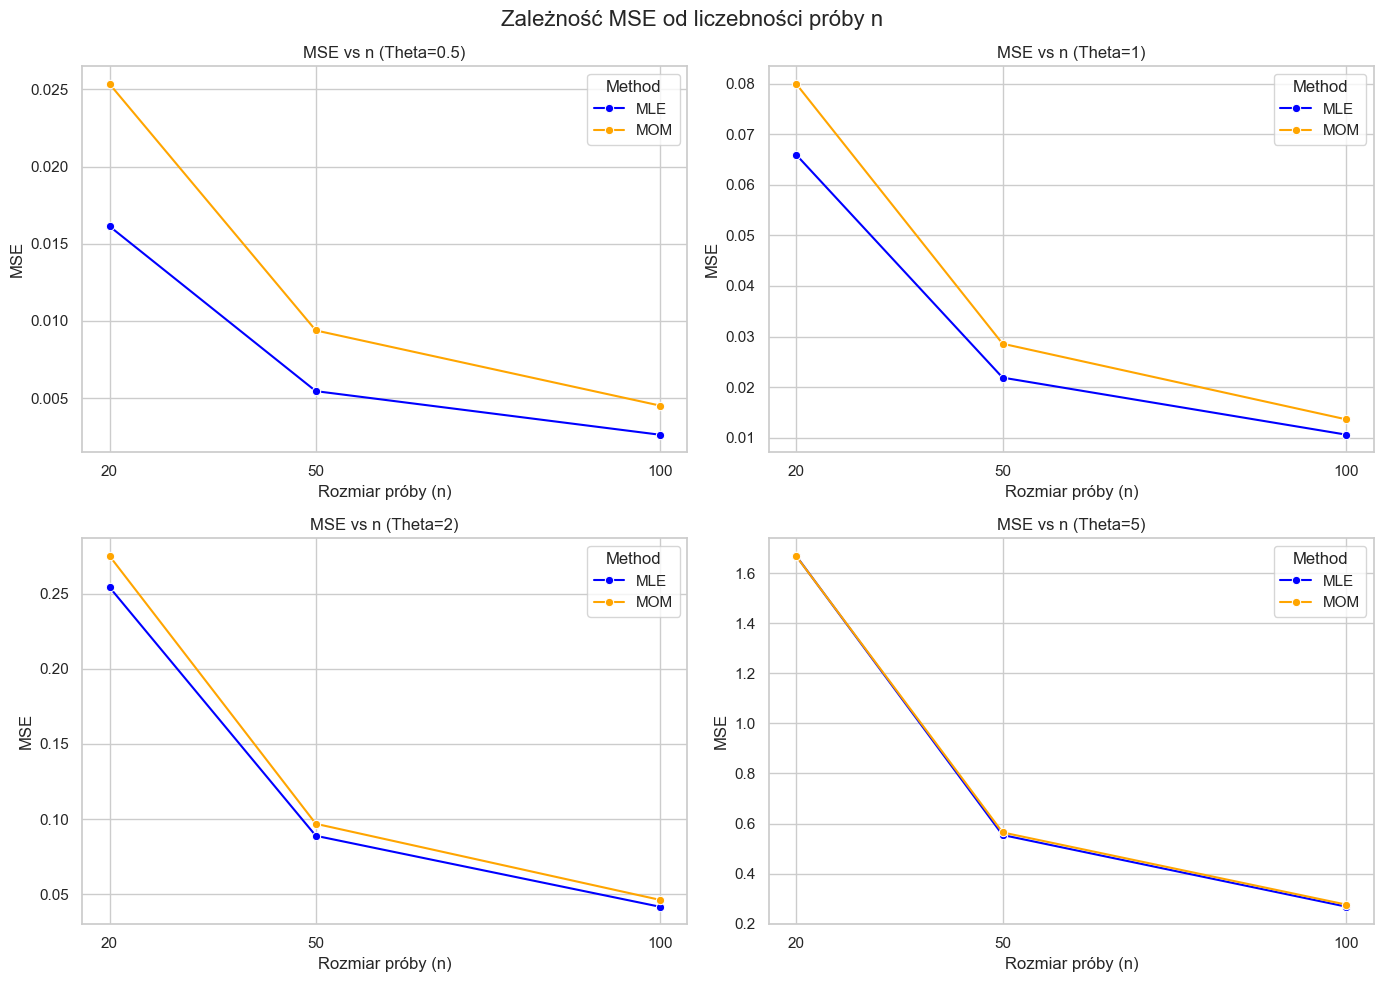

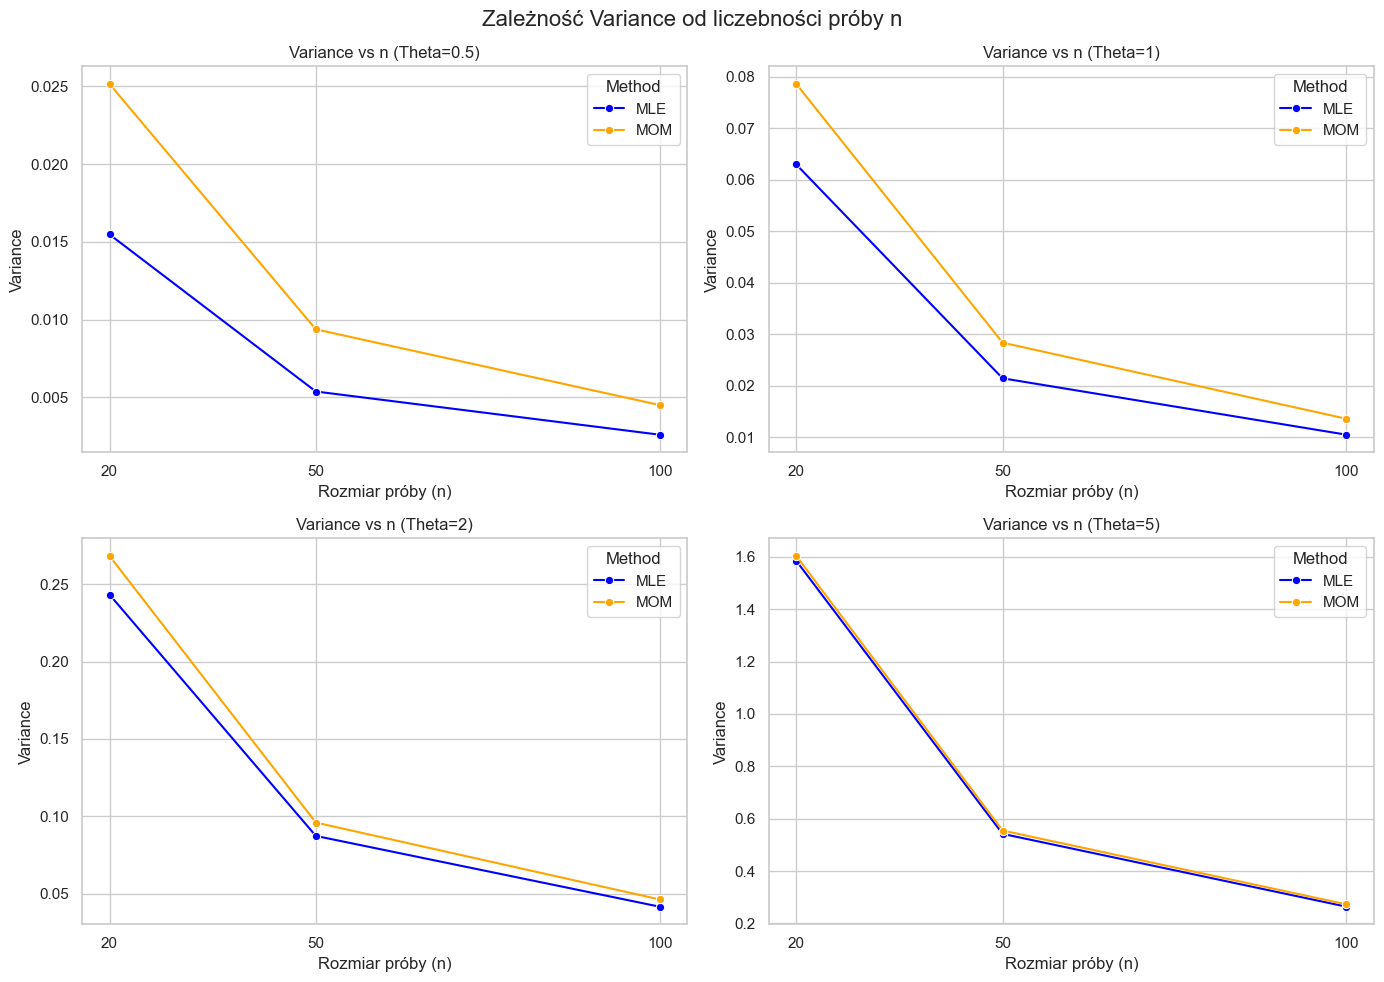

In [52]:
n_values = [20, 50, 100]
theta_values = [0.5, 1, 2, 5]

df_raw, df_metrics = run_simulation(n_values, theta_values)

plot_boxplots(df_raw, theta_values)
plot_metrics(df_metrics, theta_values)

# Zad 4.b.

In [56]:
def calculate_mle(data):
    return np.mean(np.log(data))

def calculate_mom(data, sigma):
    mean_val = np.mean(data)
    return np.log(mean_val) - (sigma**2 / 2.0)

In [57]:
def run_simulation(n_values, param_pairs, iterations=10000):
    raw_data_list = []
    metrics_list = []

    for theta, sigma in param_pairs:
        for n in n_values:
            mle_estimates = []
            mom_estimates = []
            
            for _ in range(iterations):
                sample = np.random.lognormal(mean=theta, sigma=sigma, size=n)
                
                theta_mle = calculate_mle(sample)
                theta_mom = calculate_mom(sample, sigma)
                
                mle_estimates.append(theta_mle)
                mom_estimates.append(theta_mom)
            
            mle_estimates = np.array(mle_estimates)
            mom_estimates = np.array(mom_estimates)
            
            pair_label = f"θ={theta}, σ={sigma}"
            
            df_mle = pd.DataFrame({
                'pair_label': pair_label,
                'theta': theta,
                'sigma': sigma,
                'n': n,
                'Estimate': mle_estimates,
                'Method': 'MLE'
            })
            
            df_mom = pd.DataFrame({
                'pair_label': pair_label,
                'theta': theta,
                'sigma': sigma,
                'n': n,
                'Estimate': mom_estimates,
                'Method': 'MOM'
            })
            raw_data_list.extend([df_mle, df_mom])

            bias_mle = np.mean(mle_estimates) - theta
            bias_mom = np.mean(mom_estimates) - theta
            mse_mle = np.mean((mle_estimates - theta)**2)
            mse_mom = np.mean((mom_estimates - theta)**2)
            var_mle = np.var(mle_estimates)
            var_mom = np.var(mom_estimates)
            
            metrics_list.append({'pair_label': pair_label, 'theta': theta, 'n': n, 'Method': 'MLE', 
                                 'Bias': bias_mle, 'MSE': mse_mle, 'Variance': var_mle})
            metrics_list.append({'pair_label': pair_label, 'theta': theta, 'n': n, 'Method': 'MOM', 
                                 'Bias': bias_mom, 'MSE': mse_mom, 'Variance': var_mom})

    return pd.concat(raw_data_list, ignore_index=True), pd.DataFrame(metrics_list)

In [58]:
def plot_boxplots(df_raw, param_pairs):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (theta, sigma) in enumerate(param_pairs):
        ax = axes[i]
        pair_label = f"θ={theta}, σ={sigma}"
        subset = df_raw[df_raw['pair_label'] == pair_label]
        
        sns.boxplot(data=subset, x='n', y='Estimate', hue='Method', ax=ax, palette="Set2", showfliers=False)
        
        ax.axhline(theta, color='red', linestyle='--', linewidth=2, label=f'True Theta={theta}')
        
        ax.set_title(f'Rozkład estymatorów dla {pair_label}')
        ax.set_xlabel('Rozmiar próby (n)')
        ax.set_ylabel('Wartość estymatora')
        ax.legend(loc='upper right')

    plt.suptitle('Porównanie rozkładów estymatorów (Boxploty)', fontsize=16)
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(zad4_dir, "boxplots_b.png")
    plt.savefig(plot_filename, bbox_inches='tight')

def plot_metrics(df_metrics, param_pairs):
    metrics = ['Bias', 'MSE', 'Variance']
    
    for metric in metrics:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, (theta, sigma) in enumerate(param_pairs):
            ax = axes[i]
            pair_label = f"θ={theta}, σ={sigma}"
            subset = df_metrics[df_metrics['pair_label'] == pair_label]
            
            sns.lineplot(data=subset, x='n', y=metric, hue='Method', marker='o', ax=ax, palette=['blue', 'orange'])
            
            if metric == 'Bias':
                ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
                
            ax.set_title(f'{metric} dla {pair_label}')
            ax.set_xticks([20, 50, 100])
            ax.set_xlabel('Rozmiar próby (n)')
            ax.set_ylabel(metric)
        
        plt.suptitle(f'Zależność {metric} od liczebności próby n', fontsize=16)
        plt.tight_layout()
        # plt.show()
        plot_filename = os.path.join(zad4_dir, f"{metric.lower()}_b.png")
        plt.savefig(plot_filename, bbox_inches='tight')

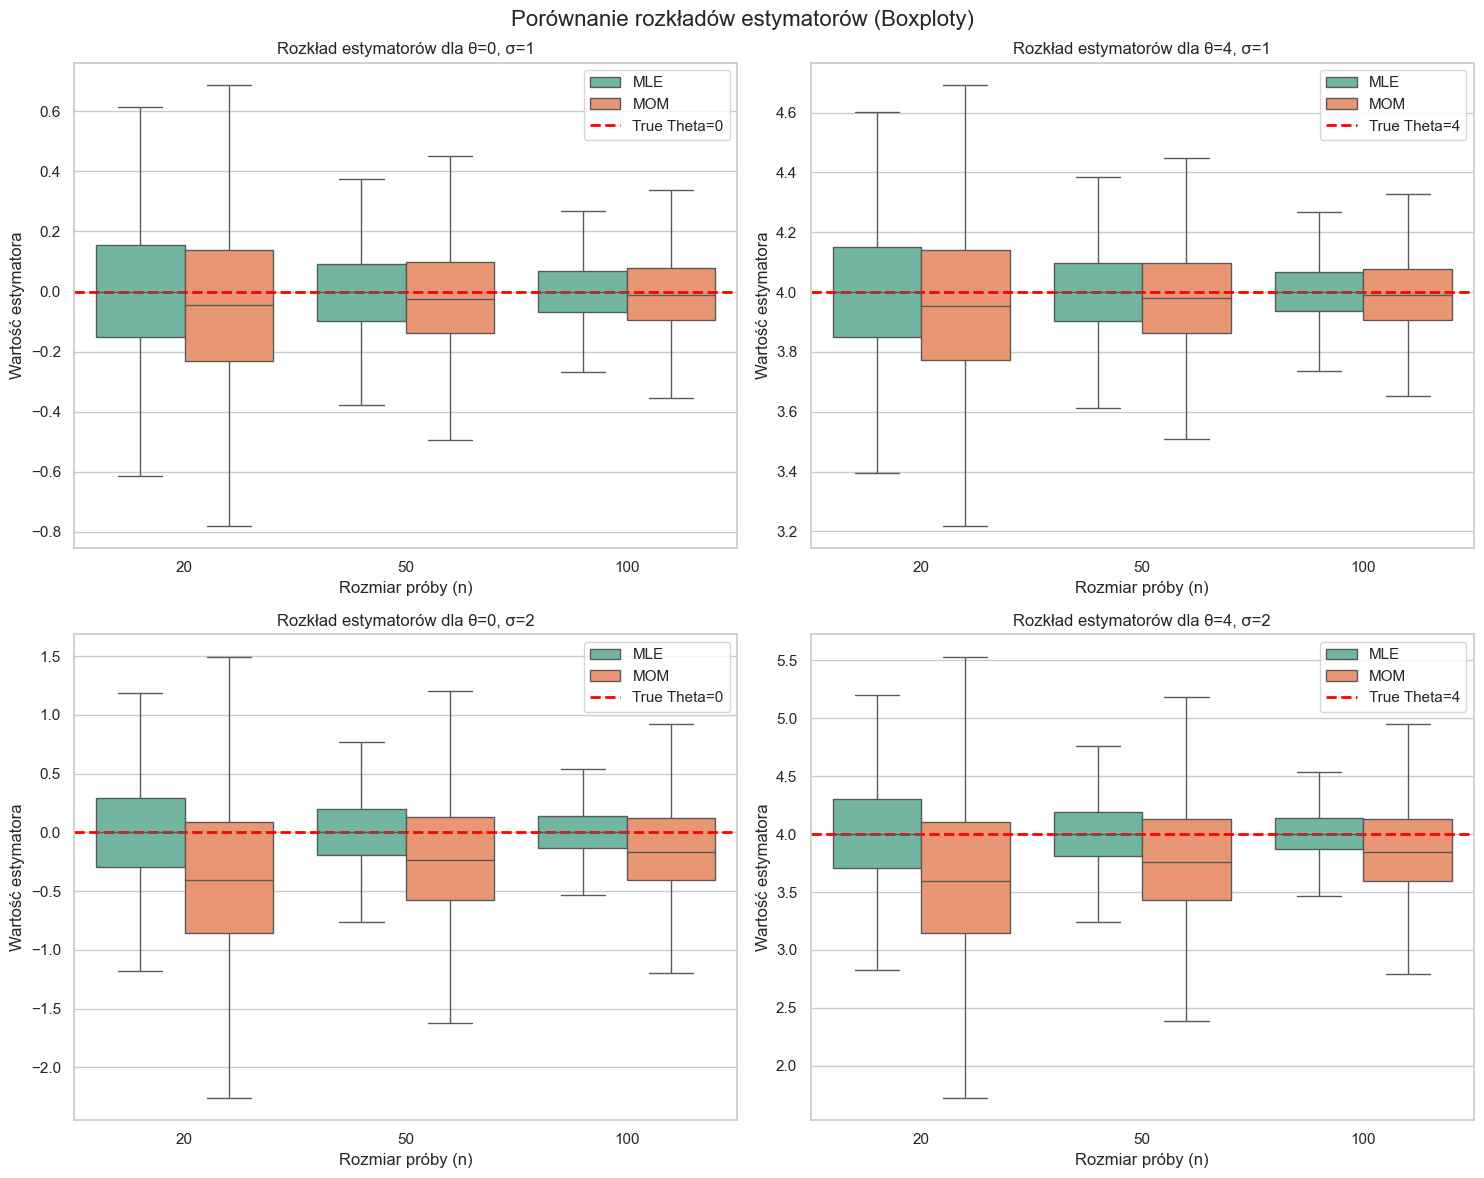

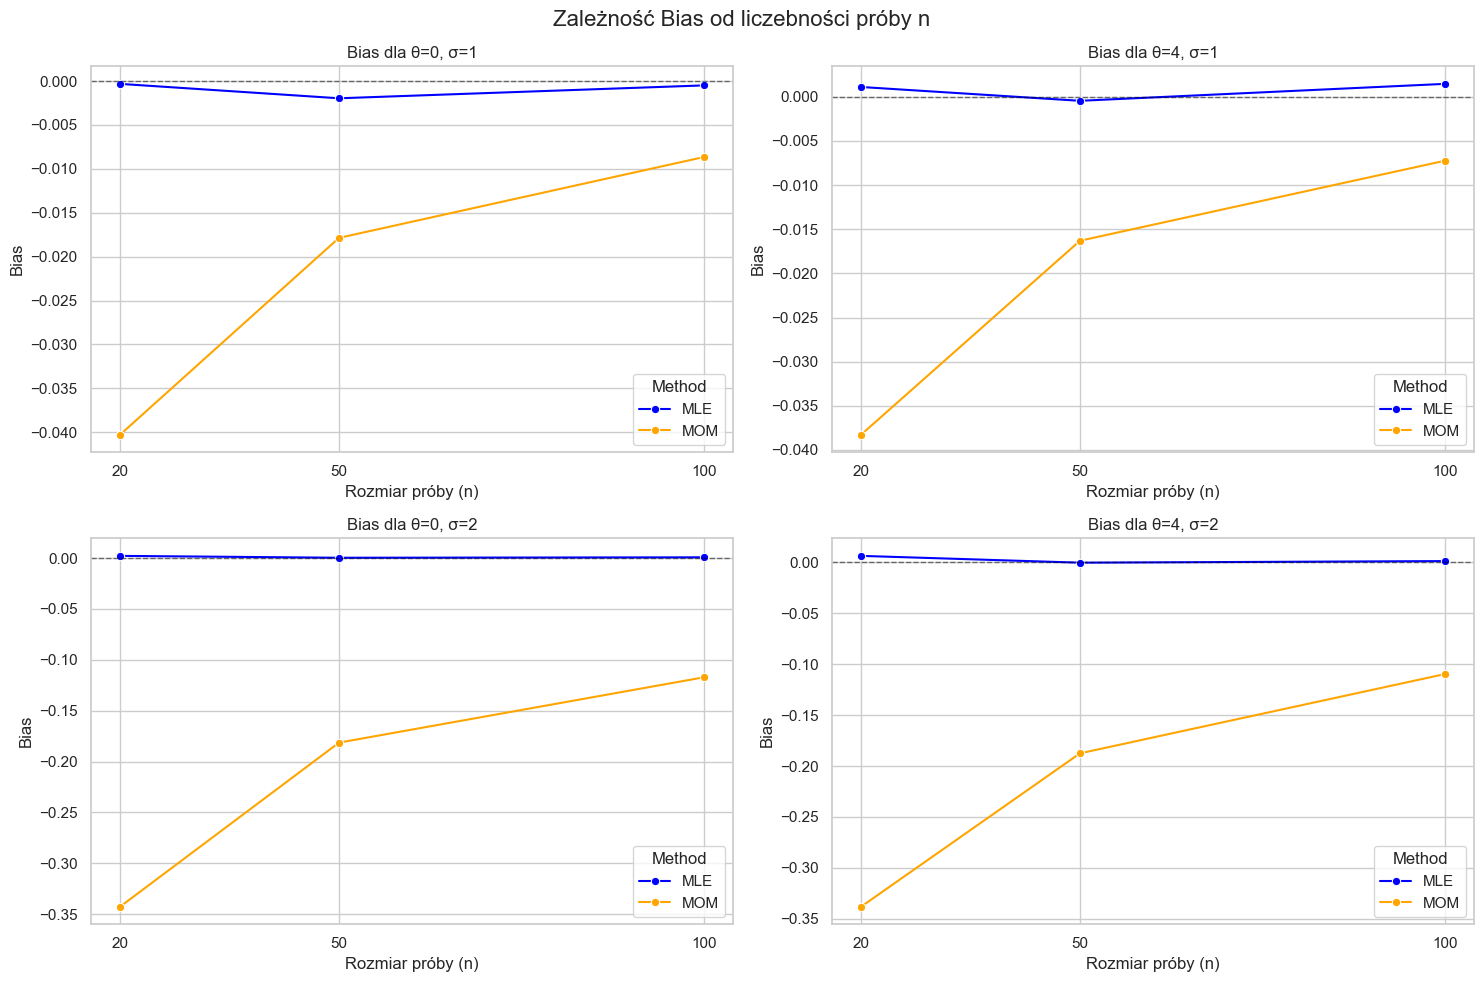

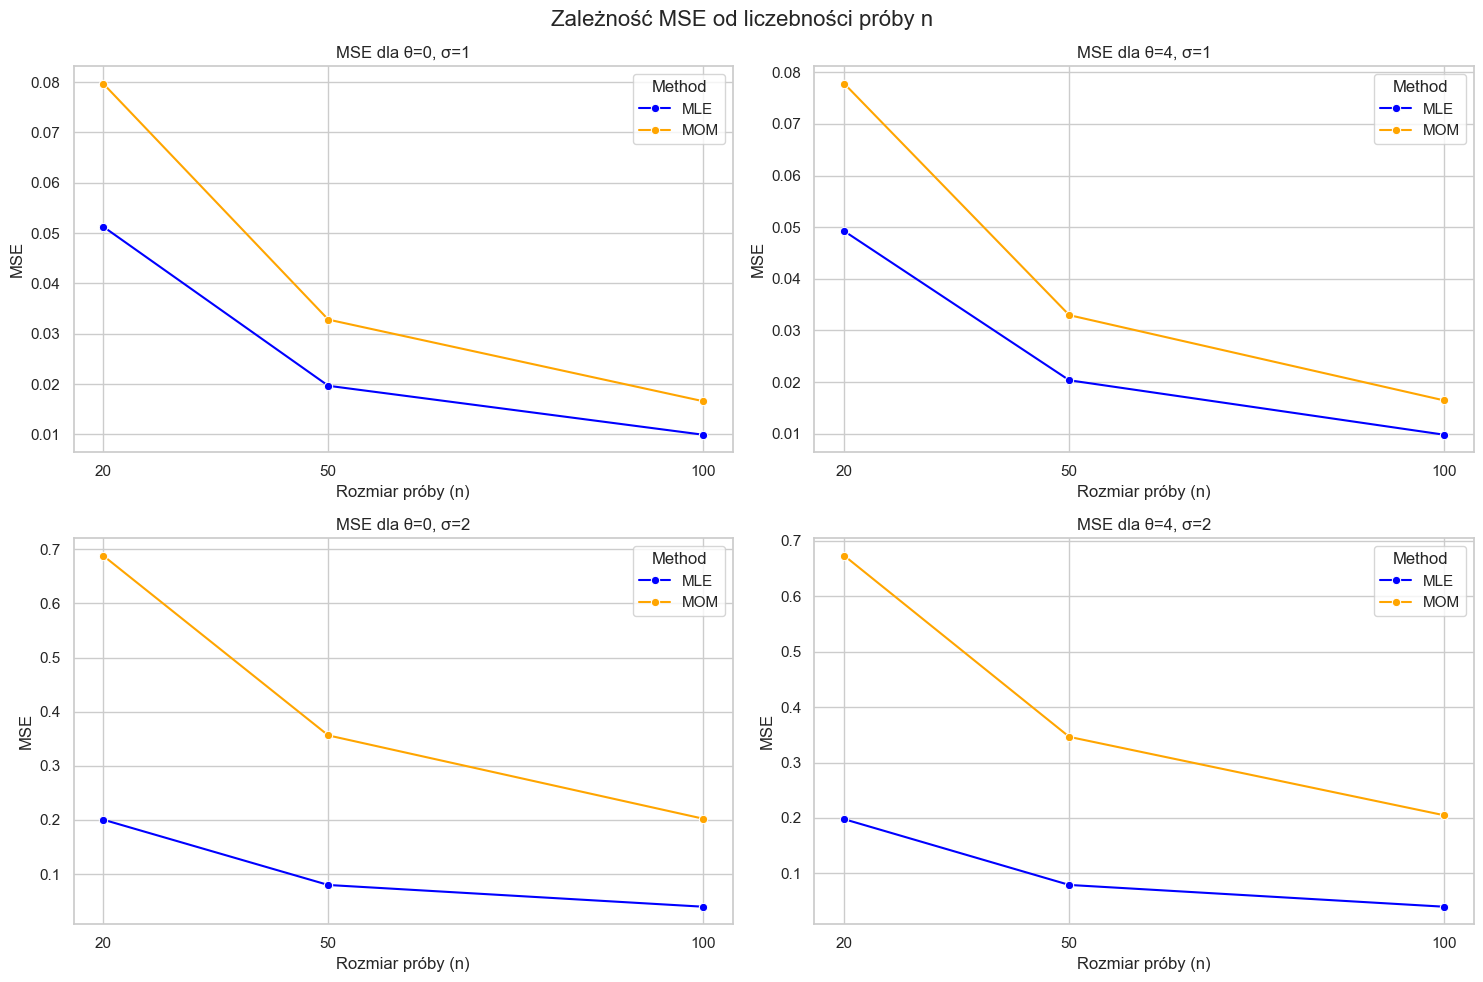

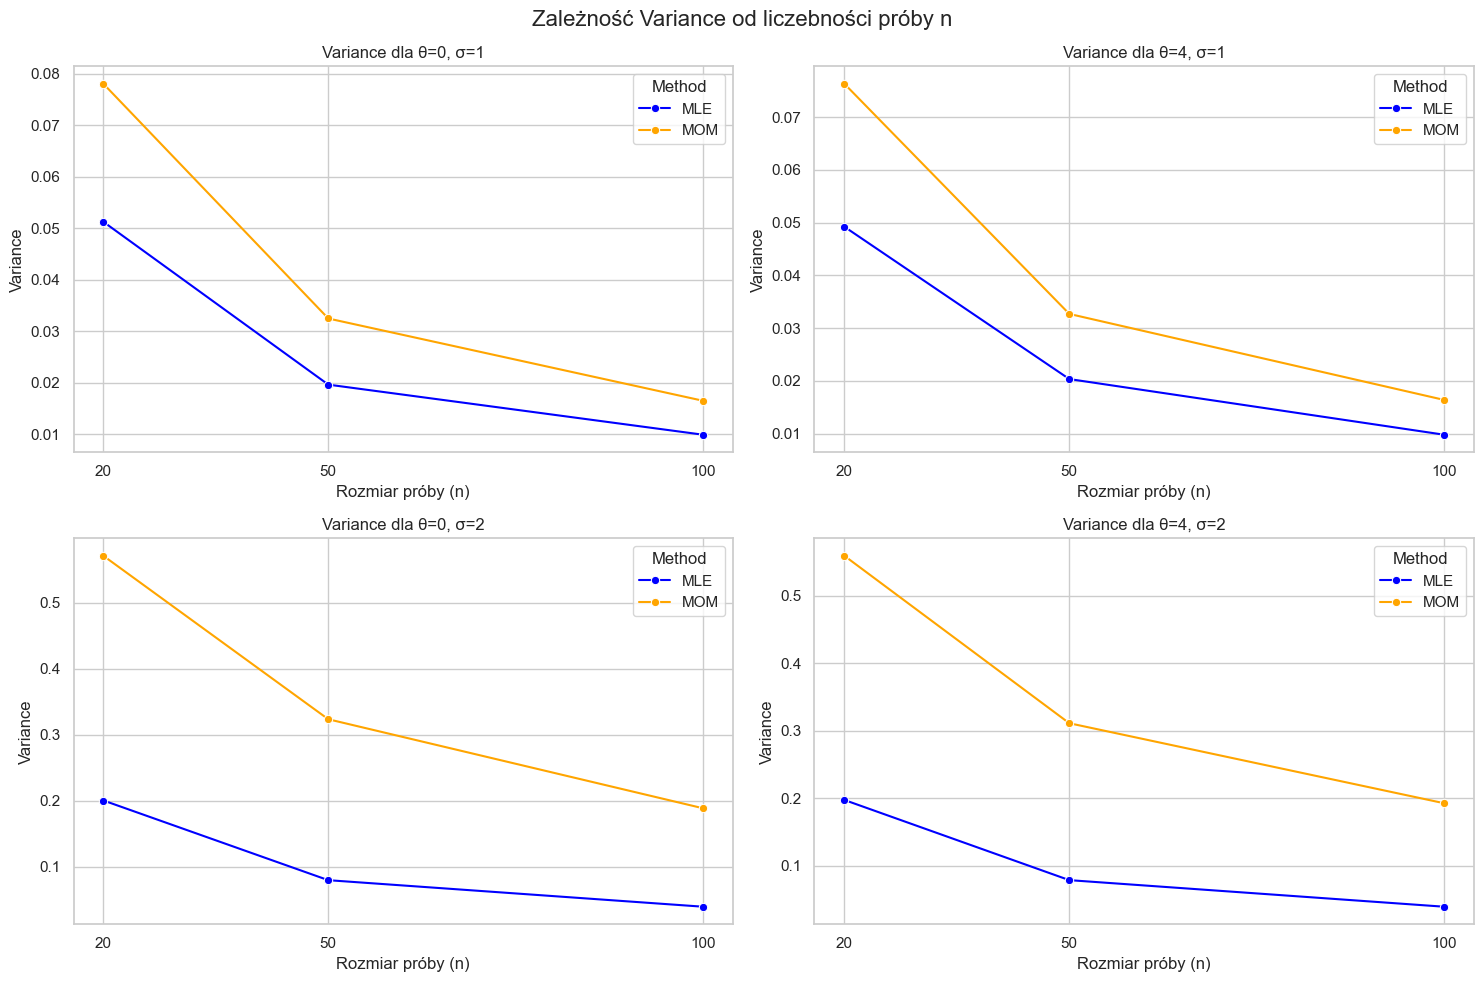

In [59]:
n_params = [20, 50, 100]
param_values = [(0, 1), (4, 1), (0, 2), (4, 2)]

df_raw, df_metrics = run_simulation(n_params, param_values)

plot_boxplots(df_raw, param_values)
plot_metrics(df_metrics, param_values)